PINN_oscillator_1D_cpu_t_mu_in_progress

# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

# Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

Here you can see an overview of the 2 dimensional space (t, mu):

<img src="excalidraw1.JPG" width="750">

## Step 1: Definition and initialization

In [1]:
### Import all what you need:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import numpy as np

import matplotlib.pyplot as plt

import time

In [2]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [3]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!

### Initial, training and test points generation:

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$


In [4]:
#### Generation of t and mu initial points (Initial condition 1) 
point_resolution = 40

ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 1: \n \t [t, mu]: \n{ic1_t_mu}")
# print(f"\n Initial condition 1: \n \t u(t=0, mu) = 1: \n {ic1_scope}")
# print(f"\n Shapes of [t, mu] and u(t=0, mu) = 1: \n\t{ic1_t_mu.shape}, {ic1_scope.shape}")
#ic1_t_mu

In [5]:
#torch.linspace(1,10,40)

In [6]:
#torch.rand(1,10, 40).shape

#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$

In [7]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 2: \n \t [t, mu]: \n{ic2_t_mu}")
#print(f"\n Initial condition 2: \n \t du/dt(t=0, mu) = 0: \n\t {ic2_scope}")
#print(f"\n Shapes of [t, mu] and du/dt(t=0, mu) = 0: \n\t {ic2_t_mu.shape}, {ic2_scope.shape}")

#### Generation of physical domain training points: 

In [8]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

#print(f" Point seed list for mesh grid domain points: \n \t {physic_in_t_mu}  \n Shape: {physic_in_t_mu[0].shape}")
#print(f"Domain training points: \n \t: {physic_domain_t_mu}")
#print(f"Size of Domain training points: \n \t {physic_domain_t_mu.size()}")


#### Generation of testing points:

In [9]:
#### Generation of t and mu test points within the domain:
point_resolution_test = 100

# Testing points:
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)

#print(f"Point seed list for mesh grid test points: \n \t \n \t: {test_in_t_mu}")
#print(f"Test points \n \t [t, mu]: \n \t {test_domain_t_mu}")
#print(f"Size of the test domain points: \n \t {test_domain_t_mu.size()}")

### Exact solution:

In [10]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [11]:
# Example to check if it works (calculation of the exact solution):
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#u_exact.view(-1,1)
#u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

In [12]:
#physic_in_t_mu[0]

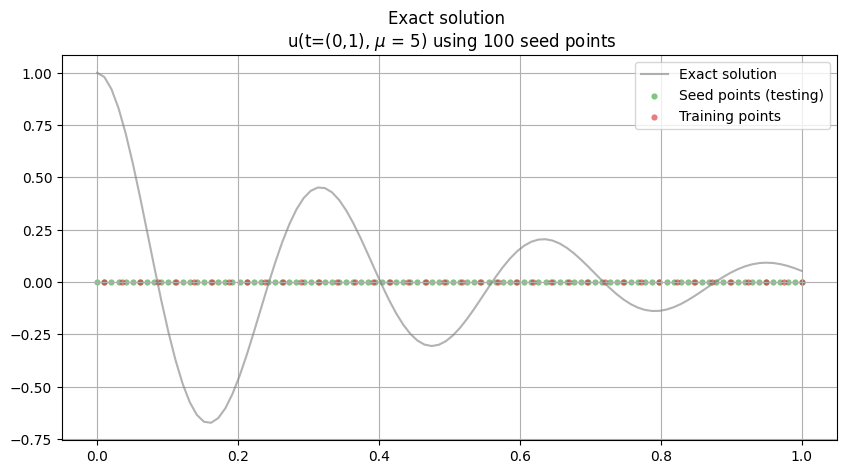

In [13]:
# Plotting the exact solution:
plt.figure(figsize=(10,5))
plt.plot(
        test_in_t_mu[0], 
        u_exact, 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points (testing)")
plt.scatter(
        physic_in_t_mu[0].detach(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= "Training points")

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {point_resolution_test} seed points")
plt.grid()
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [14]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init
# import matplotlib.pyplot as plt
# import numpy as np

class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, hidden_layers = [4], N_OUTPUT = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(N_INPUT if i == 0 else hidden_size, hidden_size),
                self.activation
            ) for i, hidden_size in enumerate(hidden_layers[:])   
        ])

        self.fco = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)

        self.plot_weights(fig_size = (10,5), font_size = 8)


    def forward(self, x):
        #x = self.activation(self.fci(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fco(x)
        return x

    def initialize_parameters(self, initialization):
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")
    
    def plot_weights(self, fig_size = (10,5), font_size = 8):
        
        self.fig_size = fig_size
        self.font_size = font_size
        
        weights_biases_dict = self.state_dict()
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize = self.fig_size)
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = self.font_size)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = self.font_size)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = self.font_size, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network', fontsize = self.font_size)
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.ax.tick_params(labelsize = self.font_size)
        
        cbar.set_label('Range of Weights and Biases', fontsize= self.font_size) 
        
        # Show the plots
        plt.show()

class FCN_extended(FCN):
    def __init__(self, N_INPUT, hidden_layers, N_OUTPUT, activation='Tanh', initialization='Xavier', original_model_path=None):
        super().__init__(N_INPUT, hidden_layers, N_OUTPUT, activation, initialization)

        #self.initialize_parameters(initialization)
        
        self.original_model_path = original_model_path
        self.original_state_dict = self.load_original_state_dict()

        self.extend_layers_neurons()
        
    def extend_layers_neurons(self):
        #current_model.initialize_parameters(initialization)  # Initialize current model first
        for name, param in self.named_parameters():
            
            if name in self.original_state_dict:                
                original_param = self.original_state_dict[name]
                
                if param.shape == original_param.shape:                    
                    param.data.copy_(original_param)   
                    
                else:
                    
                    if "weight" in name: 
                        if param.shape != original_param.shape:  
                            # Copy matching portion of old weights                     
                            param.data[:original_param.size(0), :original_param.size(1)].copy_(original_param)
                        
                        elif param.size(0) != original_param.size(0): 
                            # Copy matching portion of old weights                           
                            param.data[:original_param.size(0), :].copy_(original_param)                           
                        
                        elif param.size(0) != original_param.size(0) and "fc0" in name:                            
                            param.data[0,:original_param.size(1)].copy_(original_param[0]) 
               
                    if "bias" in name: 
                        if param.size(0) != original_param.size(0):  
                            # Copy matching portion of old weights
                            param.data[:original_param.size(0)].copy_(original_param)
                        else:
                            param.data.copy_(original_param)     
    
    def load_original_state_dict(self):
        if self.original_model_path is None:
            raise ValueError("Path to the original model checkpoint is not provided.")

        if not os.path.exists(self.self.model_path):
            raise FileNotFoundError(f"Provided path '{self.self.model_path}' does not exist.")

        if not os.path.isfile(self.self.model_path):
            raise ValueError(f"Provided path '{self.self.model_path}' is not a file.")

        _, ext = os.path.splitext(self.self.model_path)
        if ext not in ['.pt', '.pth']:
            raise ValueError("Provided file is not a valid checkpoint file.")
        
        # Load weights and biases from self.model
        return torch.load(self.self.model_path)['model_state_dict']

class TrainModel:
    def __init__(self, model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, k, test_in_t_mu, test_in_t_constant_mu, u_exact, test_mu = 5, learning_rate = 0.01, num_epochs= 20000, lambda1= 1e-1, lambda2 = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 200):
        
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.checkpoint_interval = checkpoint_interval
        self.stagnation_amplitude = stagnation_amplitude
        self.stagnation_range = stagnation_range

        self.ic1_t_mu = ic1_t_mu
        self.ic1_scope = ic1_scope
        self.ic2_scope = ic2_scope
        self.physic_in_t_mu = physic_in_t_mu
        self.physic_domain_t_mu = physic_domain_t_mu
        self.test_in_t_mu = test_in_t_mu
        self.test_in_t_constant_mu = test_in_t_constant_mu
        self.u_exact = u_exact

        self.test_mu = test_mu
        self.k = k
        self.lambda1 = lambda1
        self.lambda2 = lambda2

        self.loss_ic1_history = []
        self.loss_ic2_history = []
        self.loss_differential_equation_history = []
        self.loss_total_history = []
        self.loss_history = []
        self.max_min_range_history = []
        
        self.train()

    def plot_results(self, residuals_ic1, residuals_ic2, residuals_differential_equation, loss_ic1_history, loss_ic2_history, loss_differential_equation_history, loss_total_history, loss_history):
              
        self.test_predicted = self.model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(self.test_in_t_mu[0].detach(), 
                 self.u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                self.test_in_t_mu[0], 
                self.test_predicted[:,0].detach(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    self.physic_in_t_mu[0].detach(), 
                    torch.zeros_like(self.physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    self.test_in_t_mu[0], 
                    torch.zeros_like(self.test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        #plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation()}, epoch = {self.i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: Tanh, epoch = {self.i} \n (learning rate: {self.learning_rate}, lambda1: {self.lambda1}, lambda2: {self.lambda2})")
    
        plt.grid()
        plt.legend()
        plt.show()
        
    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr= self.learning_rate)

        start_time = time.time()
        
        for self.i in range(1, self.num_epochs + 1):
            optimizer.zero_grad()
        
            # compute initial condition 1 loss:
            self.ic1_predicted= self.model(self.ic1_t_mu)
            
            self.residuals_ic1 = self.ic1_predicted - self.ic1_scope
            
            self.loss_ic1 = torch.mean((self.ic1_predicted - self.ic1_scope)**2)
            self.loss_ic1_history.append(self.loss_ic1.item())
        
        
            # compute initial condition 2 loss:
            self.du_dtdmu_initial = torch.autograd.grad(outputs = self.ic1_predicted, inputs = self.ic1_t_mu, grad_outputs= torch.ones_like(self.ic1_predicted), create_graph= True)[0]
            self.ic2_du_dt, ic2_du_dmu = self.du_dtdmu_initial[:, 0:1], self.du_dtdmu_initial[:,1:2]
            
            self.residuals_ic2 = self.ic2_du_dt- self.ic2_scope
            
            self.loss_ic2 = torch.mean((self.ic2_du_dt- self.ic2_scope)**2)
            self.loss_ic2_history.append(self.loss_ic2.item())
        
            # compute physic loss:
            self.physic_domain_predicted = self.model(self.physic_domain_t_mu)
            self.physic_domain_du_dtdmu = torch.autograd.grad(outputs = self.physic_domain_predicted, inputs = self.physic_domain_t_mu, grad_outputs= torch.ones_like(self.physic_domain_predicted), create_graph= True)[0]
            self.physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = self.physic_domain_du_dtdmu[:,0:1], inputs = self.physic_domain_t_mu, grad_outputs= torch.ones_like(self.physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
            
            self.residuals_differential_equation = self.physic_domain_d2u_d2t_d2mu[:,0:1] + self.physic_domain_t_mu[:,1:2] * self.physic_domain_du_dtdmu[:,0:1] + self.k * self.physic_domain_predicted 
            
            self.loss_differential_equation = torch.mean( (self.physic_domain_d2u_d2t_d2mu[:,0:1] + self.physic_domain_t_mu[:,1:2] * self.physic_domain_du_dtdmu[:,0:1] + self.k * self.physic_domain_predicted )**2)
            self.loss_differential_equation_history.append(self.loss_differential_equation.item())
            
            self.loss = self.loss_ic1 + self.lambda1 * self.loss_ic2 + self.lambda2 * self.loss_differential_equation
            self.loss_total_history.append(self.loss.item())
            self.loss_history.append(self.loss.item())
            
            if self.i ==1:                
                self.initial_loss_value = self.loss.item()        
            
            self.loss.backward()
            optimizer.step()
            
            # Update loss history and ensure it contains the losses of the last check_range epochs
            if len(self.loss_history) >  self.stagnation_range:
                self.loss_history.pop(0)  # Remove the oldest loss value
            
            # Check if the difference between max and min loss in the last 100 epochs is within the threshold
            self.max_min_amplitude = max(self.loss_history) - min(self.loss_history)
            self.max_min_range_history.append(self.max_min_amplitude)
            self.absolut_loss_value = sum(self.loss_history) / len(self.loss_history)

            if len(self.loss_history) ==  self.stagnation_range and self.max_min_amplitude <= self.stagnation_amplitude and  self.absolut_loss_value < self.initial_loss_value:
                print(f"Stopping training at epoch {self.i} as the loss stabilized within the threshold.")
                print(f"max_min_amplitude = {self.max_min_amplitude} \n absolute_loss_value: {self.absolut_loss_value} ")
                break
            
            if self.i%self.checkpoint_interval == 0:
                print(f"max_min_amplitude = {self.max_min_amplitude}")
                print(f'Decomposition of the loss terms: \n loss({self.loss}) = loss1({self.loss_ic1}) + {self.lambda1} * loss2({self.loss_ic2}) + {self.lambda2} * loss3({self.loss_differential_equation})')
                self.plot_results(self.residuals_ic1, self.residuals_ic2, self.residuals_differential_equation, self.loss_ic1_history, self.loss_ic2_history, self.loss_differential_equation_history, self.loss_total_history, self.loss_history)
                torch.save({
                            "epoch": self.i,
                            "model_state_dict": self.model.state_dict(),
                            "optimiser_state_dict": optimizer.state_dict(),
                            "loss": self.loss,
                           },                    
                            f"lr{self.learning_rate}_epoch{self.i}.pth")
                print(f"Saved the checkpoint corresponding to epoch: {self.i}")
                print("*"*100)
        end_time = time.time()
        execution_time = (end_time - start_time)
        print(f"Training elapsed time (s): {execution_time}")
        torch.save({
                    "epoch": self.i,
                    "model_state_dict": self.model.state_dict(),
                    "optimiser_state_dict": optimizer.state_dict(),
                    "loss": self.loss,
                    },                    
                    f"original_model.pth") 


## STEP 3: Instantiate the Model Class

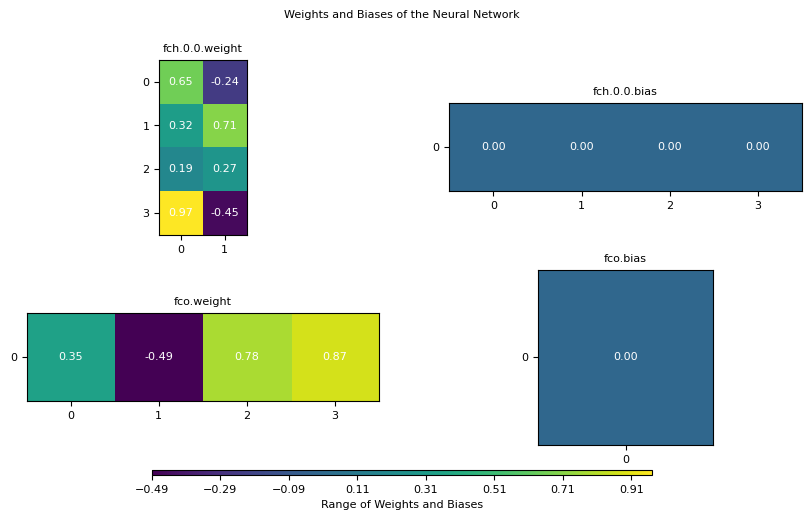

In [15]:
original_input_size = 2
original_hidden_layers = [4] #[64, 64, 64, 64] # [4]
original_output_size = 1
original_model = FCN(original_input_size, original_hidden_layers, original_output_size, activation='Tanh', initialization='Xavier')
#original_model.plot_weights()

### Checking the model using test points and a constant mu value:

In [16]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")

In [17]:
# NO es necesario porque se mantiene constante mu
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()
#print(f"Domain training points: \n \t: {test_domain_t_constant_mu}")

In [18]:
test_predicted = original_model(test_in_t_constant_mu)
#test_predicted.size()
#test_predicted

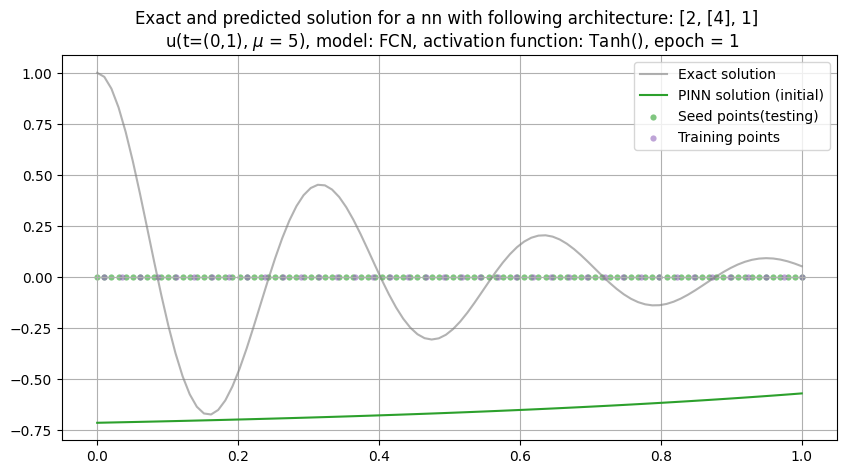

In [19]:
plt.figure(figsize=(10,5))
plt.plot(test_in_t_mu[0].detach(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
### model and activation has to be manually adapted
plt.title(f"Exact and predicted solution for a nn with following architecture: [{original_input_size}, {original_hidden_layers}, {original_output_size}] \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation}, epoch = 1")
plt.grid() 
plt.legend()
plt.show()

## STEP 4: Training the PINN

max_min_amplitude = 0.020415663719177246
Decomposition of the loss terms: 
 loss(1.057127594947815) = loss1(0.9845702052116394) + 1 * loss2(0.010487657971680164) + 0.001 * loss3(62.06973648071289)


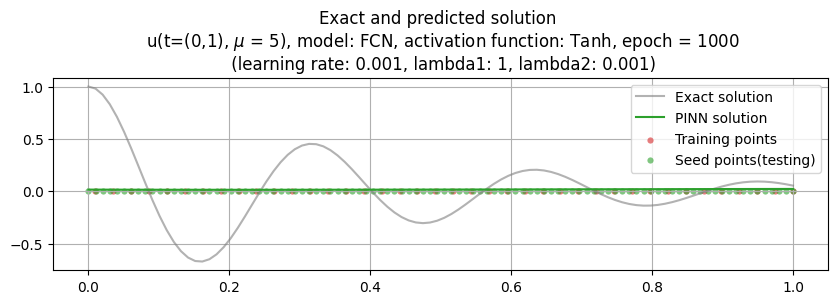

Saved the checkpoint corresponding to epoch: 1000
****************************************************************************************************
max_min_amplitude = 0.0021079182624816895
Decomposition of the loss terms: 
 loss(0.9964447021484375) = loss1(0.9439624547958374) + 1 * loss2(0.012567078694701195) + 0.001 * loss3(39.915164947509766)


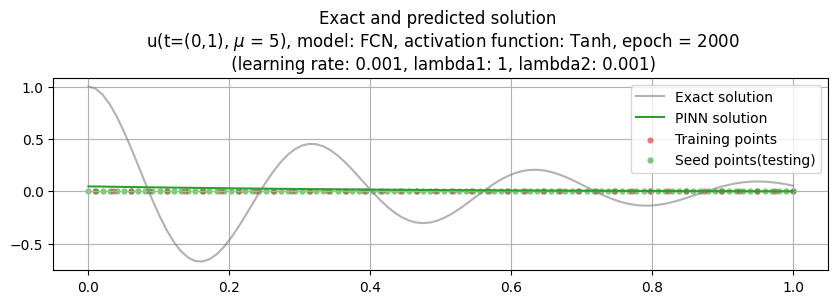

Saved the checkpoint corresponding to epoch: 2000
****************************************************************************************************
max_min_amplitude = 0.001239001750946045
Decomposition of the loss terms: 
 loss(0.9807437658309937) = loss1(0.9398193359375) + 1 * loss2(0.010780440643429756) + 0.001 * loss3(30.14398956298828)


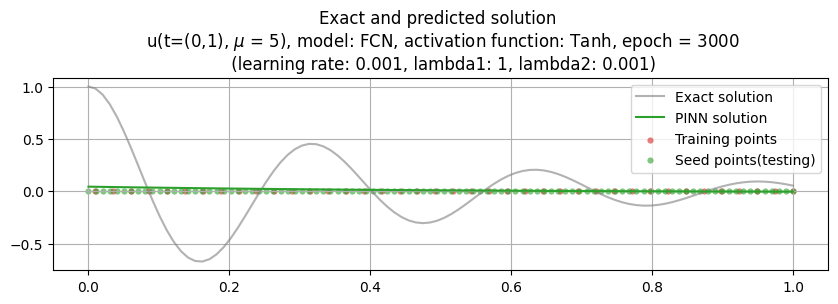

Saved the checkpoint corresponding to epoch: 3000
****************************************************************************************************
max_min_amplitude = 0.0006031990051269531
Decomposition of the loss terms: 
 loss(0.9715028405189514) = loss1(0.9375898241996765) + 1 * loss2(0.009330731816589832) + 0.001 * loss3(24.582284927368164)


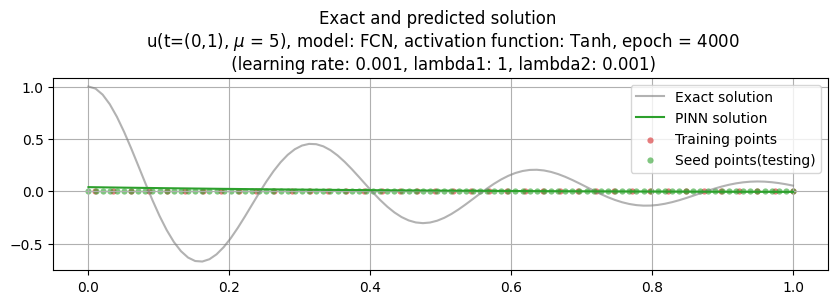

Saved the checkpoint corresponding to epoch: 4000
****************************************************************************************************
max_min_amplitude = 7.098913192749023e-05
Decomposition of the loss terms: 
 loss(0.9689087867736816) = loss1(0.9378005862236023) + 1 * loss2(0.008984211832284927) + 0.001 * loss3(22.1240177154541)


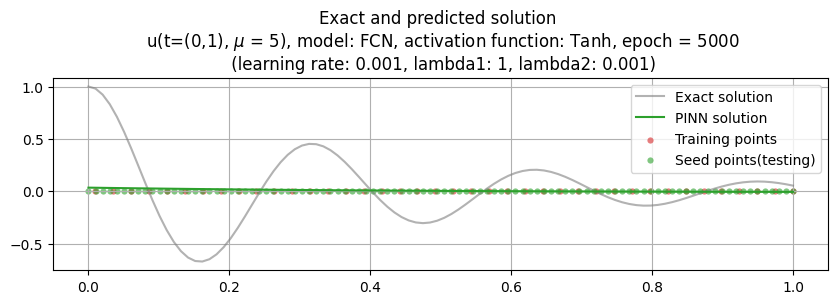

Saved the checkpoint corresponding to epoch: 5000
****************************************************************************************************
max_min_amplitude = 1.1563301086425781e-05
Decomposition of the loss terms: 
 loss(0.9686760902404785) = loss1(0.937774658203125) + 1 * loss2(0.009444870054721832) + 0.001 * loss3(21.456567764282227)


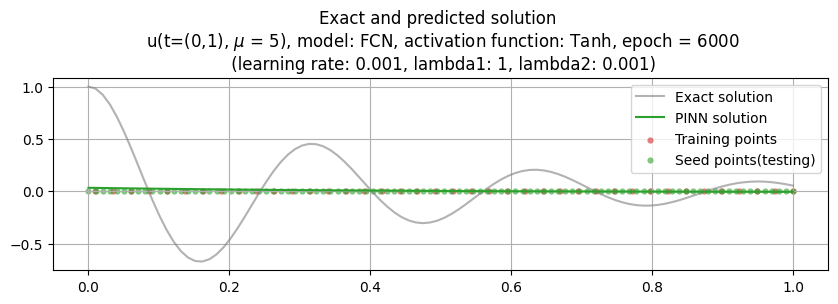

Saved the checkpoint corresponding to epoch: 6000
****************************************************************************************************
max_min_amplitude = 2.4378299713134766e-05
Decomposition of the loss terms: 
 loss(0.9685038924217224) = loss1(0.93751060962677) + 1 * loss2(0.00973951630294323) + 0.001 * loss3(21.253759384155273)


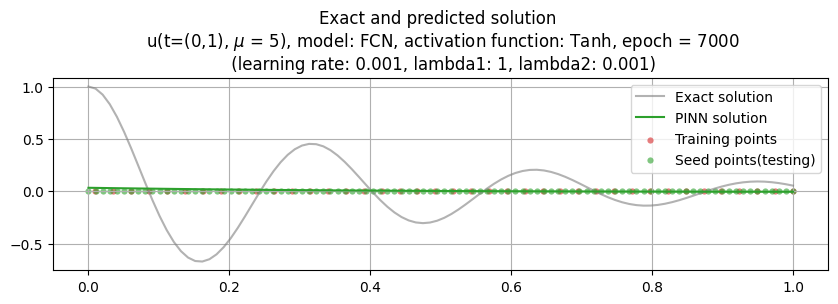

Saved the checkpoint corresponding to epoch: 7000
****************************************************************************************************
max_min_amplitude = 4.7206878662109375e-05
Decomposition of the loss terms: 
 loss(0.9681108593940735) = loss1(0.9369142651557922) + 1 * loss2(0.01016794703900814) + 0.001 * loss3(21.028635025024414)


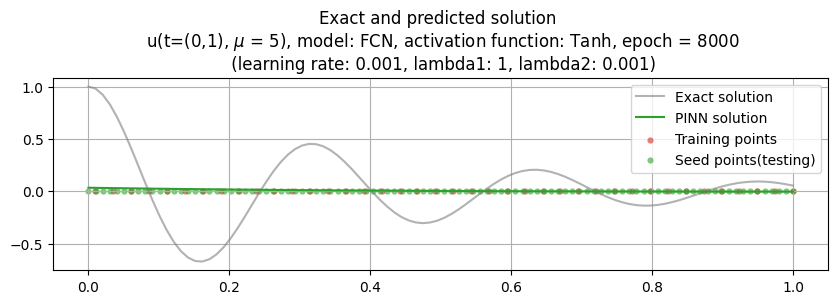

Saved the checkpoint corresponding to epoch: 8000
****************************************************************************************************
max_min_amplitude = 2.8789043426513672e-05
Decomposition of the loss terms: 
 loss(0.9677606821060181) = loss1(0.9365686178207397) + 1 * loss2(0.01035232748836279) + 0.001 * loss3(20.83974838256836)


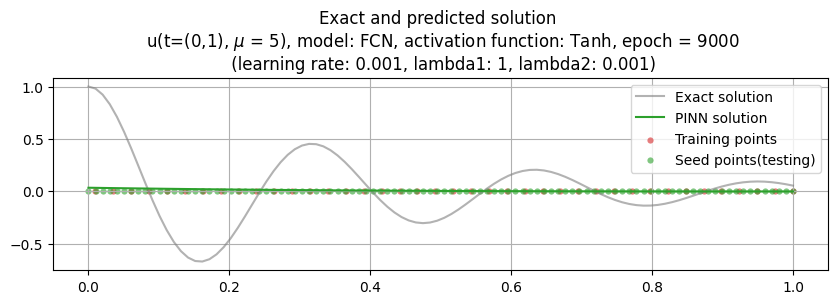

Saved the checkpoint corresponding to epoch: 9000
****************************************************************************************************
max_min_amplitude = 5.3763389587402344e-05
Decomposition of the loss terms: 
 loss(0.9673500061035156) = loss1(0.9355868101119995) + 1 * loss2(0.01057526282966137) + 0.001 * loss3(21.187936782836914)


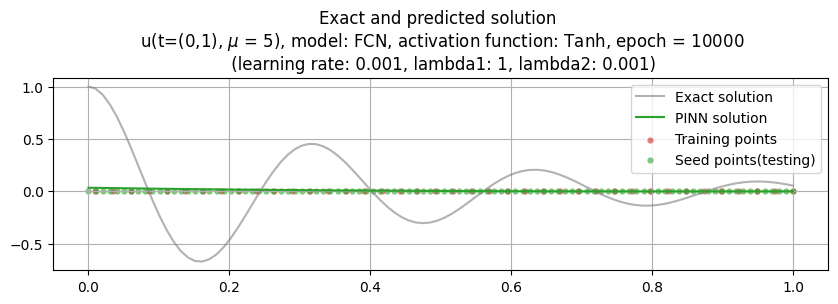

Saved the checkpoint corresponding to epoch: 10000
****************************************************************************************************
max_min_amplitude = 0.00016373395919799805
Decomposition of the loss terms: 
 loss(0.9663673639297485) = loss1(0.9335314035415649) + 1 * loss2(0.010974621400237083) + 0.001 * loss3(21.861305236816406)


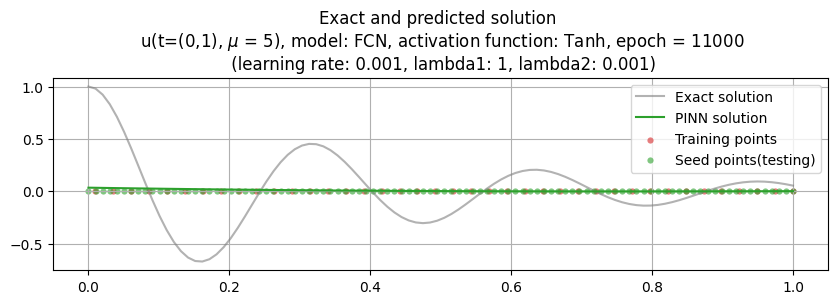

Saved the checkpoint corresponding to epoch: 11000
****************************************************************************************************
max_min_amplitude = 0.0016026496887207031
Decomposition of the loss terms: 
 loss(0.9590301513671875) = loss1(0.920566737651825) + 1 * loss2(0.006599157117307186) + 0.001 * loss3(31.864295959472656)


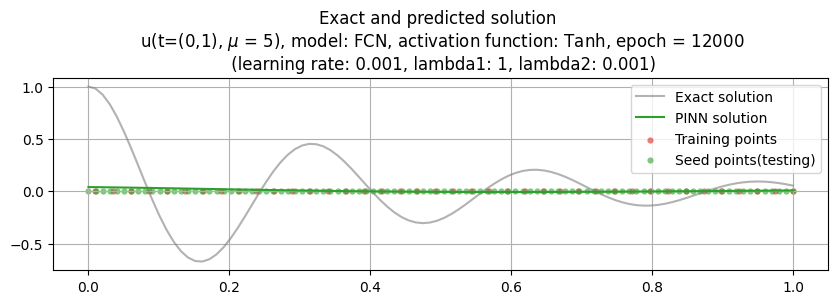

Saved the checkpoint corresponding to epoch: 12000
****************************************************************************************************
max_min_amplitude = 0.005263864994049072
Decomposition of the loss terms: 
 loss(0.9212221503257751) = loss1(0.8639823198318481) + 1 * loss2(0.0016374525148421526) + 0.001 * loss3(55.602394104003906)


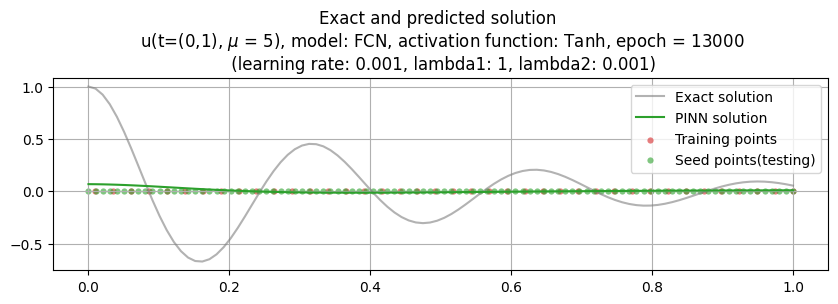

Saved the checkpoint corresponding to epoch: 13000
****************************************************************************************************
max_min_amplitude = 0.009161293506622314
Decomposition of the loss terms: 
 loss(0.8472971320152283) = loss1(0.7599731683731079) + 1 * loss2(0.0003578088362701237) + 0.001 * loss3(86.96615600585938)


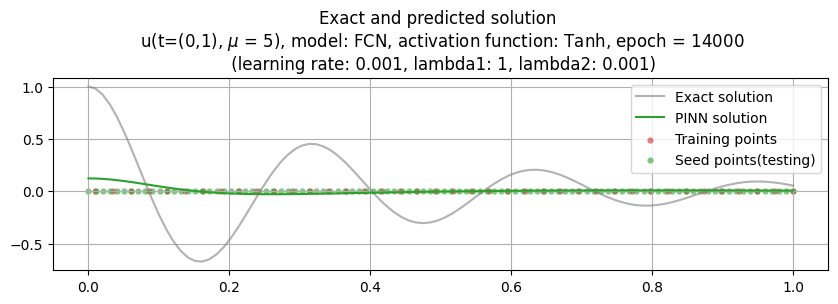

Saved the checkpoint corresponding to epoch: 14000
****************************************************************************************************
max_min_amplitude = 0.009406745433807373
Decomposition of the loss terms: 
 loss(0.747026264667511) = loss1(0.6311070919036865) + 1 * loss2(9.350280743092299e-05) + 0.001 * loss3(115.8256607055664)


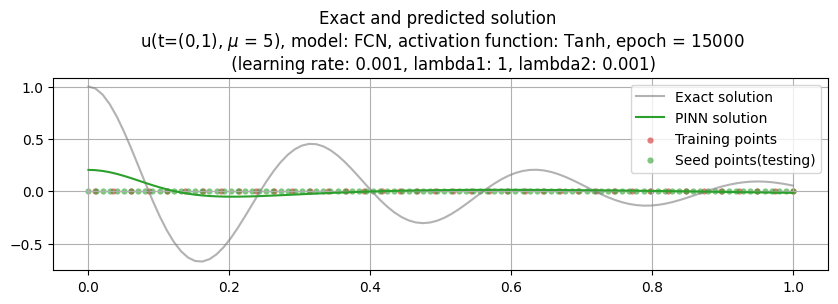

Saved the checkpoint corresponding to epoch: 15000
****************************************************************************************************
max_min_amplitude = 0.006432890892028809
Decomposition of the loss terms: 
 loss(0.666782557964325) = loss1(0.5169879198074341) + 1 * loss2(5.626331039820798e-05) + 0.001 * loss3(149.73834228515625)


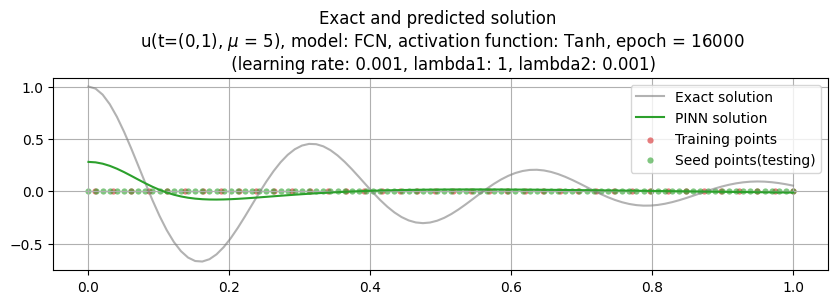

Saved the checkpoint corresponding to epoch: 16000
****************************************************************************************************
max_min_amplitude = 0.003572821617126465
Decomposition of the loss terms: 
 loss(0.6086587309837341) = loss1(0.4370325207710266) + 1 * loss2(4.868808900937438e-05) + 0.001 * loss3(171.5775146484375)


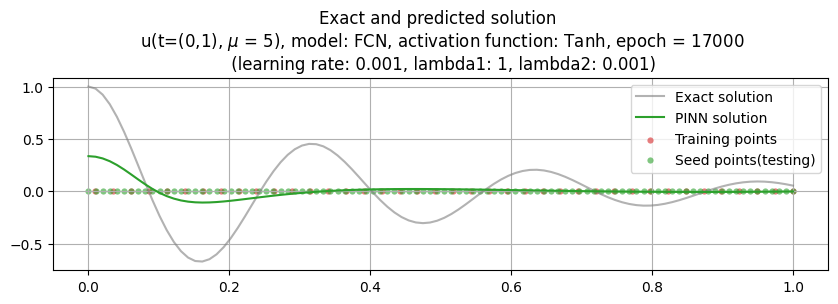

Saved the checkpoint corresponding to epoch: 17000
****************************************************************************************************
max_min_amplitude = 0.0024813413619995117
Decomposition of the loss terms: 
 loss(0.5905855894088745) = loss1(0.3951253294944763) + 1 * loss2(6.629141716985032e-05) + 0.001 * loss3(195.39395141601562)


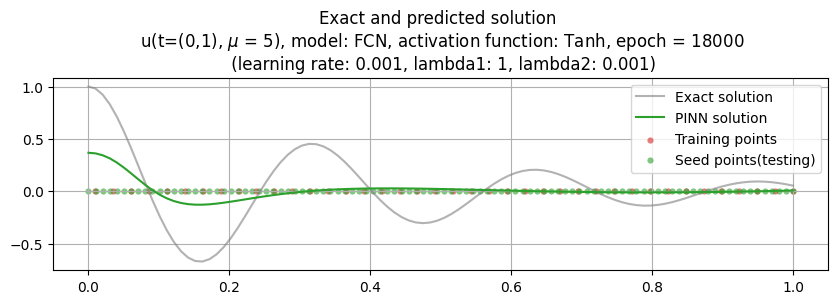

Saved the checkpoint corresponding to epoch: 18000
****************************************************************************************************
max_min_amplitude = 0.0008655190467834473
Decomposition of the loss terms: 
 loss(0.5846315026283264) = loss1(0.38071873784065247) + 1 * loss2(7.206401642179117e-05) + 0.001 * loss3(203.8406982421875)


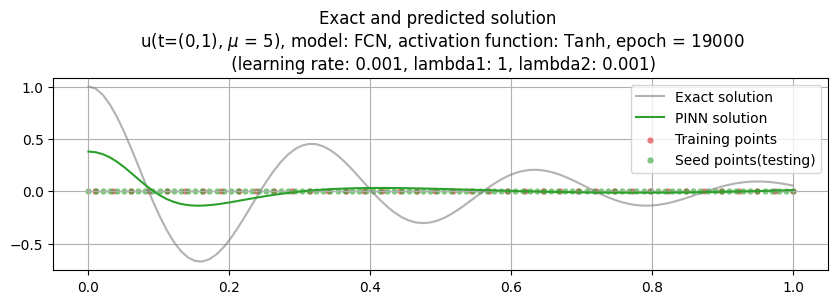

Saved the checkpoint corresponding to epoch: 19000
****************************************************************************************************
max_min_amplitude = 0.0023002028465270996
Decomposition of the loss terms: 
 loss(0.5797034502029419) = loss1(0.37426847219467163) + 1 * loss2(9.020837751450017e-05) + 0.001 * loss3(205.34478759765625)


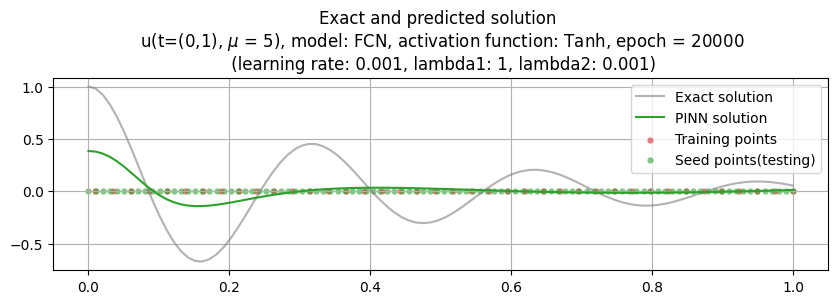

Saved the checkpoint corresponding to epoch: 20000
****************************************************************************************************
Training elapsed time (s): 68.03074645996094


In [20]:
# Train original model
#train_model = TrainModel(original_model, num_epochs=1000, checkpoint_interval=100, loss_threshold=0.01)
#train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_domain_t_mu, k, learning_rate = 0.0001, num_epochs= 20000, lambda1= 1e-1, lambda2 = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 200)
train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, k, test_in_t_mu, test_in_t_constant_mu, u_exact, test_mu = 5, learning_rate = 1e-3, num_epochs= 20000, lambda1= 1, lambda2 = 1e-3, checkpoint_interval = 1000, stagnation_amplitude= 0.00001, stagnation_range = 100)

In [ ]:
original_model.plot_weights(fig_size = (10,5), font_size = 8)

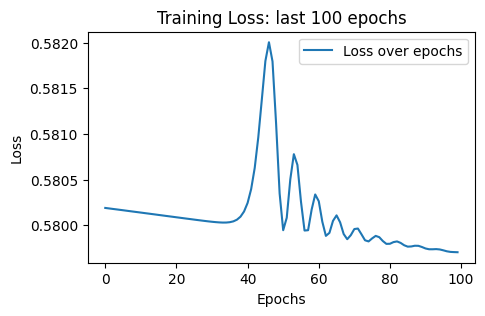

In [21]:
# Plot the loss history as before
plt.figure(figsize=(5, 3))
plt.plot(train_model.loss_history, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss: last 100 epochs')
plt.legend()
plt.show()


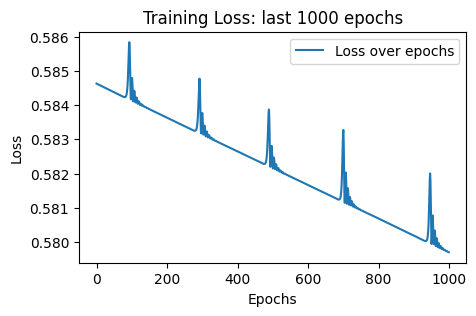

In [22]:
plt.figure(figsize=(5, 3))
plt.plot(train_model.loss_total_history[-1000:], label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss: last 1000 epochs')
plt.legend()
plt.show()

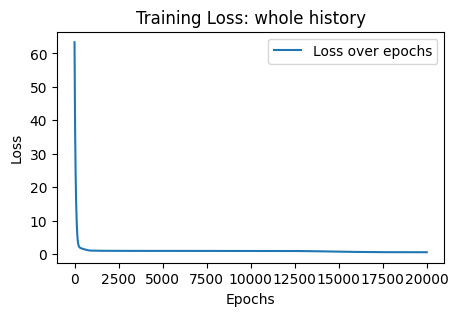

In [23]:
plt.figure(figsize=(5, 3))
plt.plot(train_model.loss_total_history, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss: whole history')
plt.legend()
plt.show()

## STEP 5: Investigation of the loss terms

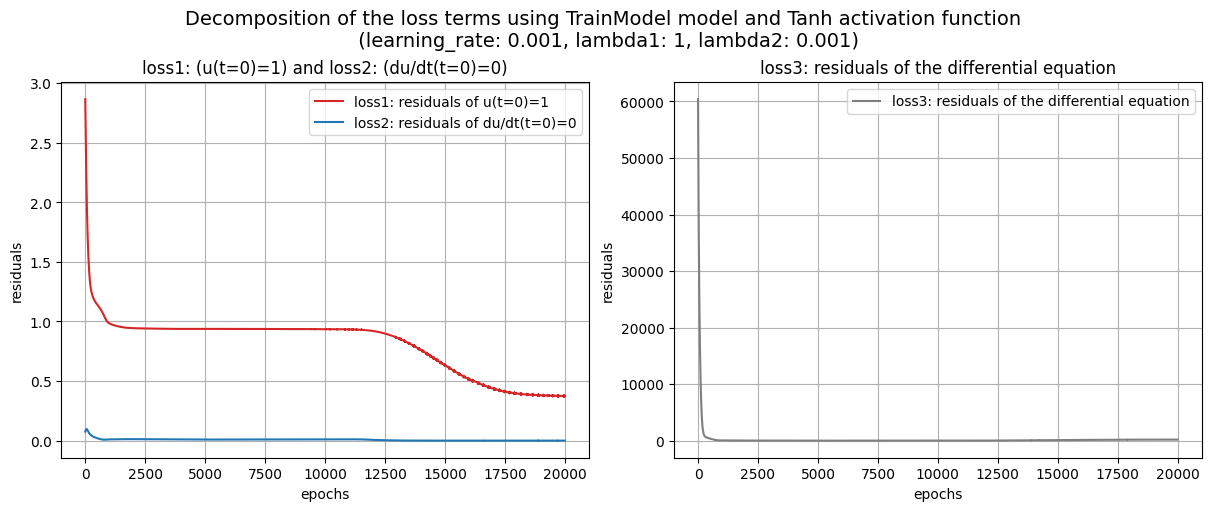

In [24]:
# plot the contribution of every loss term (loss1, loss2 and loss3)
fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (12,5))
#fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh #{original_model.activation()}# activation function \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)
fig.suptitle(f"Decomposition of the loss terms using {train_model.__class__.__name__} model and Tanh activation function \n (learning_rate: {train_model.learning_rate}, lambda1: {train_model.lambda1}, lambda2: {train_model.lambda2})", fontsize = 14)

loss1_2.plot(train_model.loss_ic1_history, label = "loss1: residuals of u(t=0)=1", color = "tab:red")
loss1_2.plot(train_model.loss_ic2_history, label = "loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
loss1_2.set_title("loss1: (u(t=0)=1) and loss2: (du/dt(t=0)=0)")
loss1_2.set_xlabel("epochs")
loss1_2.set_ylabel("residuals")
loss1_2.grid()
loss1_2.legend()

loss3.plot(train_model.loss_differential_equation_history, label= "loss3: residuals of the differential equation", color = "tab:grey")
loss3.set_title("loss3: residuals of the differential equation")
loss3.set_xlabel("epochs")
loss3.set_ylabel("residuals")
loss3.legend()
loss3.grid()

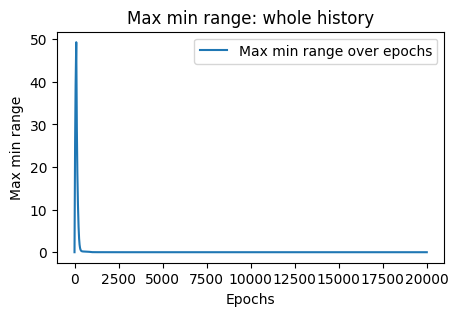

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(train_model.max_min_range_history, label='Max min range over epochs')
plt.xlabel('Epochs')
plt.ylabel('Max min range')
plt.title('Max min range: whole history')
plt.legend()
plt.show()

## STEP 6: Inference/Prediction with a constant mu

In [26]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size

<function Tensor.size>

In [27]:
test_predicted = original_model(test_in_t_constant_mu)

In [28]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])

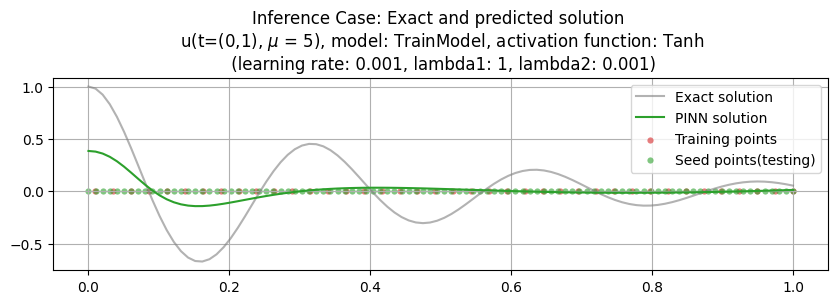

In [29]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_in_t_mu[0].detach(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_in_t_mu[0], 
            torch.zeros_like(test_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {train_model.test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda1: {train_model.lambda1}, lambda2: {train_model.lambda2})")
plt.grid()
plt.legend()
plt.show()

# STEP 7: extension of the model

In [ ]:
# Create extended model
extended_input_size = 2
extended_hidden_layers = [4,4]
extended_output_size = 1
extended_model = FCN_extended(extended_input_size, extended_hidden_layers, extended_output_size, activation='Tanh', initialization='Xavier', original_model_path='original_model.pt')

In [ ]:
extended_model.plot_weights(fig_size = (10,5), font_size = 8)

## Inference/Prediction for checking a correct initialization of the extended model

In [ ]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size

In [ ]:
test_predicted_extended_model = extended_model(test_in_t_constant_mu)

In [ ]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])

In [ ]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_in_t_mu[0].detach(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted_extended_model[:,0].detach(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_in_t_mu[0], 
            torch.zeros_like(test_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {train_model.test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda1: {train_model.lambda1}, lambda2: {train_model.lambda2})")
plt.grid()
plt.legend()
plt.show()